<a href="https://colab.research.google.com/github/vinay10949/AnalyticsAndML/blob/master/FeatureSelection/FilterMethods/1_10_Univariate_roc_auc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Univariate roc-auc or mse

This procedure works as follows:

- First, it builds one decision tree per feature, to predict the target
- Second, it makes predictions using the decision tree and the mentioned feature
- Third, it ranks the features according to the machine learning metric (roc-auc or mse)
- It selects the highest ranked features

I will demonstrate how to select features based on univariate roc-auc or univariate mse information on a regression and classification problem. For classification I will use the Paribas claims dataset from Kaggle. For regression, the House Price dataset from Kaggle.

In [1]:
!pip install --user kaggle
!mkdir .kaggle

In [8]:
import json
token = {"username":"###","key":"####"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c bnp-paribas-cardif-claims-management
!unzip train.csv.zip

 91% 45.0M/49.4M [00:00<00:00, 49.3MB/s]
100% 49.4M/49.4M [00:00<00:00, 77.7MB/s]
  0% 0.00/162k [00:00<?, ?B/s]
100% 162k/162k [00:00<00:00, 148MB/s]
 63% 31.0M/49.4M [00:00<00:00, 68.6MB/s]
100% 49.4M/49.4M [00:00<00:00, 141MB/s] 
Archive:  train.csv.zip
  inflating: train.csv               


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, mean_squared_error

In [10]:
# load dataset
data = pd.read_csv('train.csv', nrows=50000)
data.shape

(50000, 133)

In [11]:
data.head()

,ID,target,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,...,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130,v131
0,3,1,1.335739,8.727474,C,3.921026,7.915266,2.599278,3.176895,0.012941,9.999999,0.503281,16.434108,6.085711,2.866830,11.636387,1.355013,8.571429,3.670350,0.106720,0.148883,18.869283,7.730923,XDX,-1.716131e-08,C,0.139412,1.720818,3.393503,0.590122,8.880867,C,A,1.083033,1.010829,7.270147,8.375452,11.326592,0.454546,0,...,0.442252,5.814018,3.517720,0.462019,7.436824,5.454545,8.877414,1.191337,19.470199,8.389237,2.757375,4.374296,1.574039,0.007294,12.579184,E,2.382692,3.930922,B,0.433213,O,NaN,15.634907,2.857144,1.951220,6.592012,5.909091,-6.297423e-07,1.059603,0.803572,8.000000,1.989780,0.035754,AU,1.804126,3.113719,2.024285,0,0.636365,2.857144
1,4,1,NaN,NaN,C,NaN,9.191265,NaN,NaN,2.301630,NaN,1.312910,NaN,6.507647,NaN,11.636386,NaN,NaN,NaN,NaN,NaN,NaN,6.763110,GUV,NaN,C,3.056144,NaN,NaN,NaN,NaN,C,A,NaN,NaN,3.615077,NaN,14.579479,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,8.303967,NaN,NaN,NaN,NaN,NaN,NaN,1.505335,NaN,B,1.825361,4.247858,A,NaN,U,G,10.308044,NaN,NaN,10.595357,NaN,NaN,NaN,NaN,NaN,NaN,0.598896,AF,NaN,NaN,1.957825,0,NaN,NaN
2,5,1,0.943877,5.310079,C,4.410969,5.326159,3.979592,3.928571,0.019645,12.666667,0.765864,14.756098,6.384670,2.505589,9.603542,1.984127,5.882353,3.170847,0.244541,0.144258,17.952332,5.245035,FQ,-2.785053e-07,E,0.113997,2.244897,5.306122,0.836005,7.499999,NaN,A,1.454082,1.734693,4.043864,7.959184,12.730517,0.259740,0,...,0.271480,5.156559,4.214944,0.309657,5.663265,5.974026,11.588858,0.841837,15.491329,5.879353,3.292788,5.924457,1.668401,0.008275,11.670572,C,1.375753,1.184211,B,3.367348,S,NaN,11.205561,12.941177,3.129253,3.478911,6.233767,-2.792745e-07,2.138728,2.238806,9.333333,2.477596,0.013452,AE,1.773709,3.922193,1.120468,2,0.883118,1.176472
3,6,1,0.797415,8.304757,C,4.225930,11.627438,2.097700,1.987549,0.171947,8.965516,6.542669,16.347483,9.646653,3.903302,14.094723,1.945044,5.517242,3.610789,1.224114,0.231630,18.376407,7.517125,ACUE,-4.805344e-07,D,0.148843,1.308269,2.303640,8.926662,8.874521,C,B,1.587644,1.666667,8.703550,8.898468,11.302795,0.433735,0,...,0.763925,5.498902,3.423944,0.832518,7.375480,6.746988,6.942002,1.334611,18.256352,8.507281,2.503055,4.872157,2.573664,0.113967,12.554274,B,2.230754,1.990131,B,2.643678,J,NaN,13.777666,10.574713,1.511063,4.949609,7.180722,5.655086e-01,1.166281,1.956521,7.018256,1.812795,0.002267,CJ,1.415230,2.954381,1.990847,1,1.677108,1.034483
4,8,1,NaN,NaN,C,NaN,NaN,NaN,NaN,NaN,NaN,1.050328,NaN,6.320087,NaN,10.991098,NaN,NaN,NaN,NaN,NaN,NaN,6.414567,HIT,NaN,E,NaN,NaN,NaN,NaN,NaN,NaN,A,NaN,NaN,6.083151,NaN,NaN,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C,NaN,NaN,A,NaN,T,G,14.097099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Z,NaN,NaN,NaN,0,NaN,NaN


In [12]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(50000, 114)

### Important

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [13]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target', 'ID'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 112), (15000, 112))

In [0]:
# loop to build a tree, make predictions and get the roc-auc
# for each feature of the train set

roc_values = []
for feature in X_train.columns:
    clf = DecisionTreeClassifier()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict_proba(X_test[feature].fillna(0).to_frame())
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))

In [15]:
# let's add the variable names and order it for clearer visualisation
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False)

v10     0.625163
v50     0.591156
v14     0.579888
v129    0.573197
v62     0.566037
          ...   
v85     0.496781
v28     0.496571
v73     0.496035
v18     0.495597
v16     0.490329
Length: 112, dtype: float64

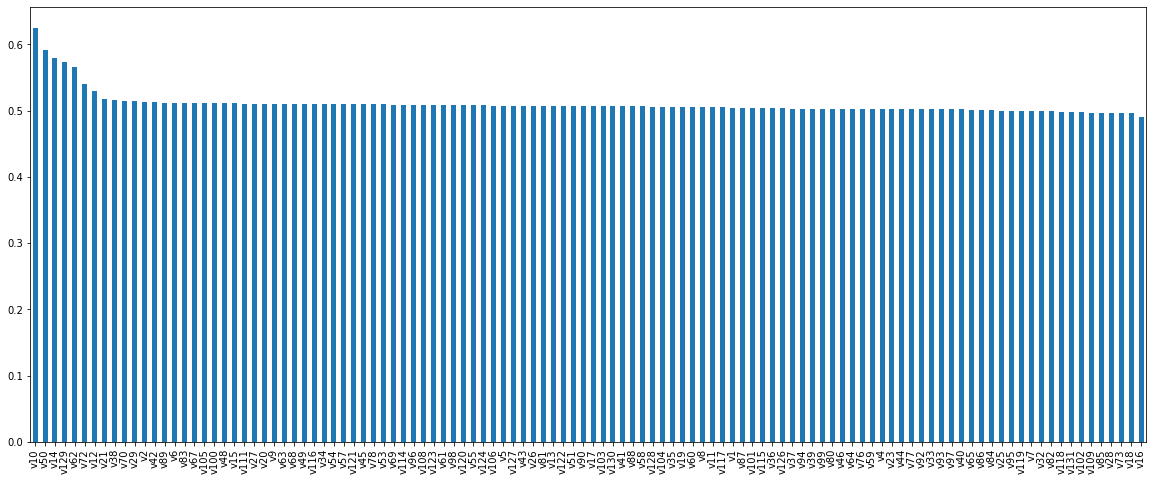

In [16]:
# and now let's plot
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 8))

In [17]:
# a roc auc value of 0.5 indicates random decision
# let's check how many features show a roc-auc value
# higher than random

len(roc_values[roc_values > 0.5])

98

98 of 112  features show a predictive performance higher than 0.5. This means that we could remove 14 features from this dataset using this method.

You can of course tune the parameters of the Decision Tree and get better predictions. I leave this to you. But remember that the key here is not to make ultra predictive Decision Trees, rather to use them to screen quickly for important features. So I would recommend you don't spend too much time tuning. Doing cross validation with sklearn should be very straight forward  to get a more accurate measure of the roc-auc per feature.

Once again, where we put the cut-off to select features is a bit arbitrary, other than > 0.5. It will be up to you.

### Regression

In [0]:
# load dataset
data = pd.read_csv('houseprice_train.csv')
data.shape

(1460, 81)

In [0]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [0]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 37), (438, 37))

In [0]:
# loop to build a tree, make predictions and get the mse
# for each feature of the train set
mse_values = []
for feature in X_train.columns:
    clf = DecisionTreeRegressor()
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)
    y_scored = clf.predict(X_test[feature].fillna(0).to_frame())
    mse_values.append(mean_squared_error(y_test, y_scored))

In [0]:
# let's add the variable names and order it for clearer visualisation
mse_values = pd.Series(mse_values)
mse_values.index = X_train.columns
mse_values.sort_values(ascending=False)

Id               1.326803e+10
BsmtUnfSF        1.011789e+10
LotArea          8.379937e+09
MasVnrArea       7.867109e+09
BsmtFinSF1       7.696158e+09
WoodDeckSF       7.271460e+09
3SsnPorch        6.948829e+09
OpenPorchSF      6.886315e+09
MoSold           6.875928e+09
YrSold           6.832078e+09
LotFrontage      6.827291e+09
PoolArea         6.816711e+09
BsmtFinSF2       6.806977e+09
BsmtHalfBath     6.798179e+09
EnclosedPorch    6.797342e+09
MiscVal          6.791047e+09
LowQualFinSF     6.764285e+09
ScreenPorch      6.707080e+09
KitchenAbvGr     6.665297e+09
BedroomAbvGr     6.642833e+09
1stFlrSF         6.496486e+09
BsmtFullBath     6.486271e+09
HalfBath         6.072529e+09
OverallCond      6.026309e+09
2ndFlrSF         5.816917e+09
TotalBsmtSF      5.669278e+09
Fireplaces       5.295673e+09
MSSubClass       5.258424e+09
GrLivArea        5.208607e+09
YearRemodAdd     5.138584e+09
TotRmsAbvGrd     5.076108e+09
GarageArea       4.960935e+09
YearBuilt        4.776575e+09
GarageYrBl

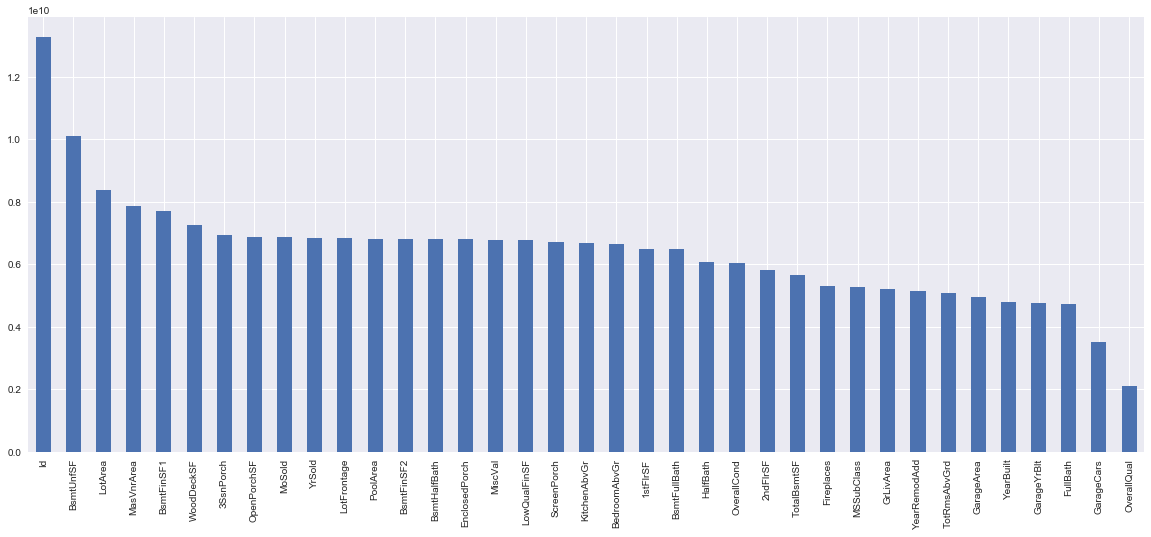

In [0]:
mse_values.sort_values(ascending=False).plot.bar(figsize=(20,8))

Remember that for regression, the smaller the mse, the better the model performance is. So in this case, we need to select from the right to the left.

For the mse, where to put the cut-off is arbitrary as well. It depends on how many features you would like to end up with.

I do use this method in my projects, particularly when I have an enormous amount of features and I need to start reducing the feature space quickly.
